# **Modeling - Data Split**




In [1]:
#Models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("/content/drive/MyDrive/IBE/4th Semester/Master Thesis/Codes/Data/frenchclaim_prep.csv")   #data prepared

In [4]:
# Define response name and features names
#Exposure and ClaimNb are not included in the model as it is part of the calculation of Freq

#Freq is the response variable, group_id used only in terms of split
y, x = df.columns[1], list(df.loc[:, ~df.columns.isin(['Freq', 'group_id', 'Unnamed: 0'])])

print("The response name:", y)
print("The feature names:", x)

The response name: Freq
The feature names: ['VehPower', 'VehAge', 'VehBrand', 'VehGas', 'DrivAge', 'logDensity', 'PolicyRegion']


In [5]:
# split the data into 80% training and 20% test
# Split data into test/train set

# Stratified split by group_id to minimize bias
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['group_id'])
train_inds, test_inds = next(split)

train = df.iloc[train_inds]
test = df.iloc[test_inds]

# **Deep neural net**

**Model set up according to the paper:**
SHAP for Actuaries: Explain any Model (Mayer, 2023)

In [6]:
!pip install Tensorflow==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 32.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goo

In [7]:
# Scale features to [-1, 1]
from sklearn.preprocessing import MinMaxScaler

nn_preprocessor = MinMaxScaler(feature_range=(-1, 1))
X_train = nn_preprocessor.fit_transform(train[x])

print("Test of the scaling function")
pd.DataFrame(X_train[0:4], columns=x)

Test of the scaling function


,VehPower,VehAge,VehBrand,VehGas,DrivAge,logDensity,PolicyRegion
0,-0.75,-1.0,0.692308,1.0,0.104478,0.392479,0.710843
1,-0.75,-1.0,0.692308,1.0,0.104478,0.392479,0.710843
2,-0.50,-0.8,0.692308,-1.0,0.014925,-0.218122,-0.734940
3,-0.25,-1.0,0.692308,-1.0,-0.164179,-0.151136,0.469880


In [8]:
seed_value= 0
import tensorflow as tf
tf.random.set_seed(seed_value)
from tensorflow import keras
import keras.backend as K
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

cb = [EarlyStopping(patience=20), ReduceLROnPlateau(patience=5)]

# Architecture
inputs = keras.Input(shape=(len(x),))
z = layers.Dense(40, activation="tanh")(inputs) #adding layers using Dense
z = layers.Dense(20, activation="tanh")(z)
z = layers.Dense(10, activation="tanh")(z)
outputs = layers.Dense(1, activation="exponential")(z)
model_nn = keras.Model(inputs=inputs, outputs=outputs)

model_nn.summary()

# Calculate gradients
model_nn.compile(optimizer=Adam(learning_rate=1e-4), loss="Poisson")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 40)                320       
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [9]:
tf.random.set_seed(4349)

history = model_nn.fit(
    x=X_train,
    y=train[y],
    epochs=200,
    batch_size=10_000,
    validation_split=0.1,
    callbacks=cb,
    verbose=0,
)

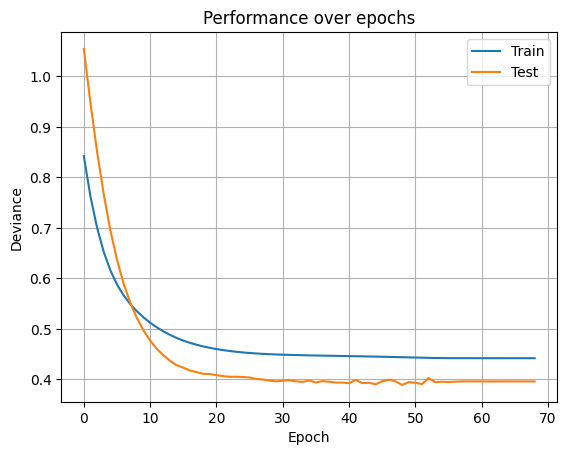

In [10]:
#The loss function (also known as the cost function) quantifies
#how well the model’s predictions match the actual target values.
for data, label in zip(("loss", "val_loss"), ("Train", "Test")):
    plt.plot(history.history[data], label=label)
plt.legend()
plt.grid()
_ = plt.gca().set(title="Performance over epochs", xlabel="Epoch", ylabel="Deviance")

In [11]:
model_nn.fit(X_train, train[y])

16957/16957 [==============================] - 35s 2ms/step - loss: 0.4371


In [12]:
# Prediction
y_pred = model_nn.predict(test[x])

In [13]:
#Mean Poisson deviance regression loss.
#out-of-sample on the test data set
deviance = mean_poisson_deviance(test[y], y_pred)
print(f"Mean Poisson Deviance: {deviance:.4f}")

Mean Poisson Deviance: 1.1990


In [14]:
#mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test[y], y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1.2711


#**SHAP** **analysis**

Select explanation data

In [15]:
X_explain = train[x].sample(n=1000, random_state=937)
print("Shape of X_explain:", X_explain.shape)

Shape of X_explain: (1000, 7)


In [16]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.3 MB/s eta 0:00:00


In [17]:
# Background data (same for the GLM, the neural net, and the true model)
X_bg = train[x].sample(200, random_state=8366)

# How many subsets with 7 features?
nsamples = 2 ** len(x) - 2

# **Neural Net with Deep SHAP**

In [18]:
# Perform standardization
scaler = StandardScaler()
scaler.fit(X_bg)
X_bg_norm = scaler.transform(X_bg)
X_explain_norm = scaler.transform(X_explain)

In [19]:
print("SHAP version is:", shap.__version__)
print("Tensorflow version is:", tf.__version__)

SHAP version is: 0.46.0
Tensorflow version is: 2.8.0


In [20]:
explainer_nn = shap.DeepExplainer(model_nn, X_bg_norm)
shap_nn= explainer_nn.shap_values(X_explain_norm)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [21]:
np.shape(shap_nn)

#reshape
shap_nn2 = shap_nn.reshape((1000,7))

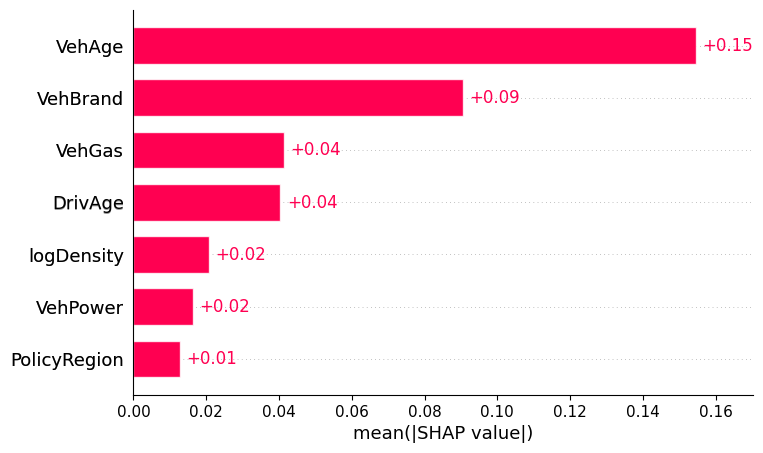

In [22]:
shap.plots.bar(shap.Explanation(values=shap_nn2, feature_names=X_explain.columns))

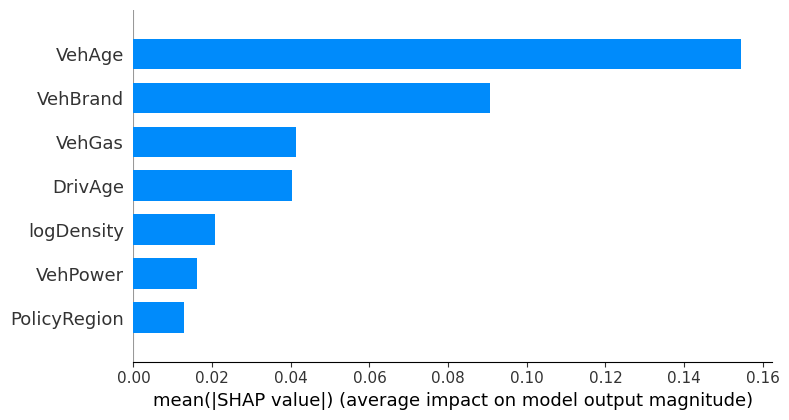

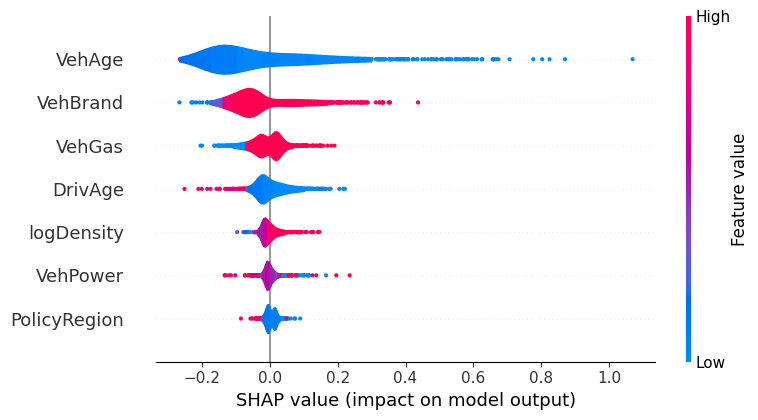

In [23]:
for t in ("bar", "violin"):
    shap.summary_plot(shap_nn2, features=X_explain, plot_type=t, title=t)

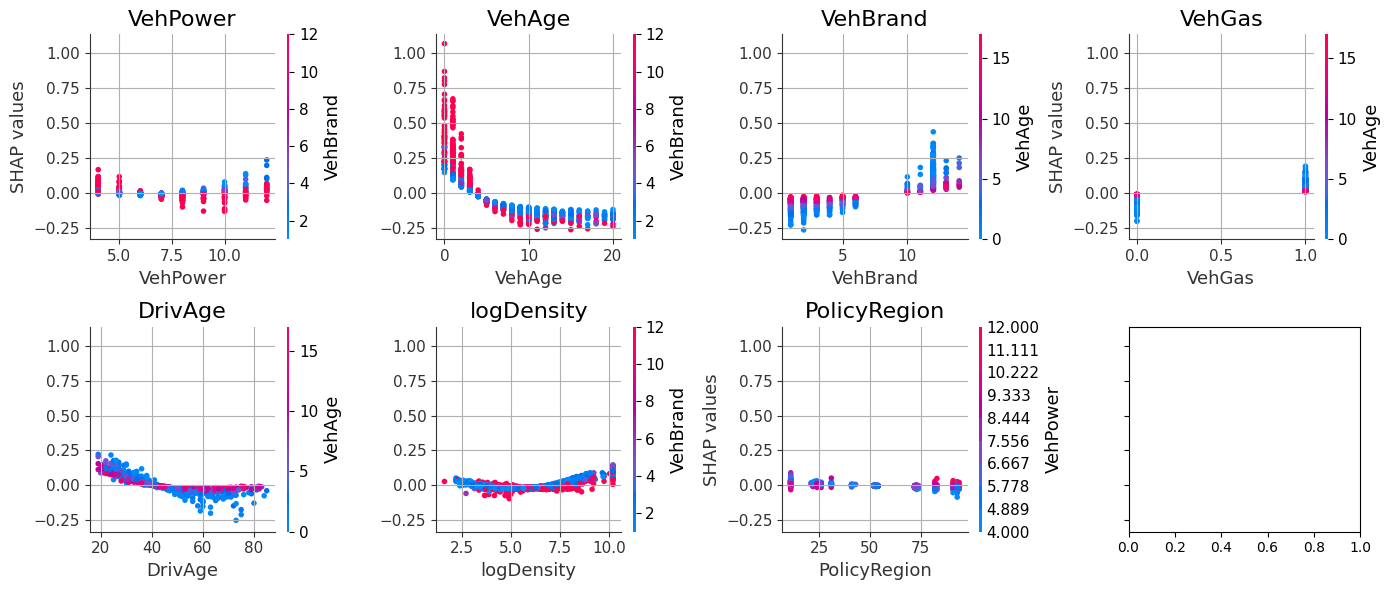

In [24]:
def all_dep_plots(x, shap_values, X):
    """Dependence plots for all features x."""
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6), sharey=True)

    for i, ax in enumerate(axes.flat):
        if i < len(x):
            xvar = x[i]
            shap.dependence_plot(
                xvar,
                shap_values,
                features=X,
                # x_jitter=0.2,
                # ymin=-ymin,
                # ymax=1,
                ax=ax,
                show=False,
            )
            ax.set_title(xvar, fontdict={"size": 16})
            ax.set_ylabel("SHAP values" if i % 3 == 0 else "")
            ax.grid()

    plt.tight_layout()

# Call the modified function with your data
all_dep_plots(x, shap_nn2, X_explain)

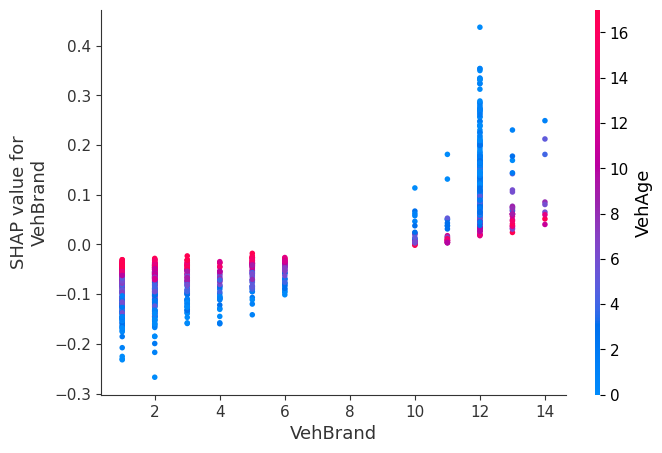

In [25]:
shap.dependence_plot(2, shap_nn2, X_explain)

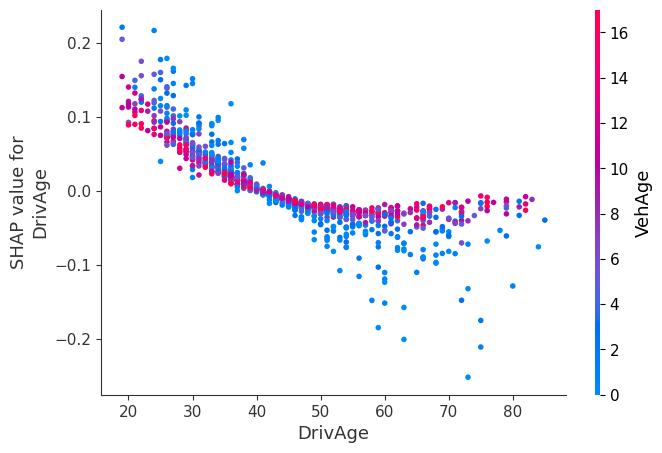

In [26]:
shap.dependence_plot(4, shap_nn2, X_explain)

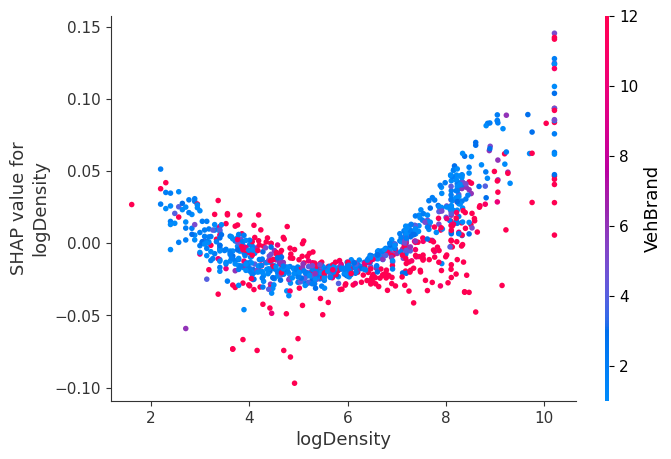

In [27]:
shap.dependence_plot(5, shap_nn2, X_explain)

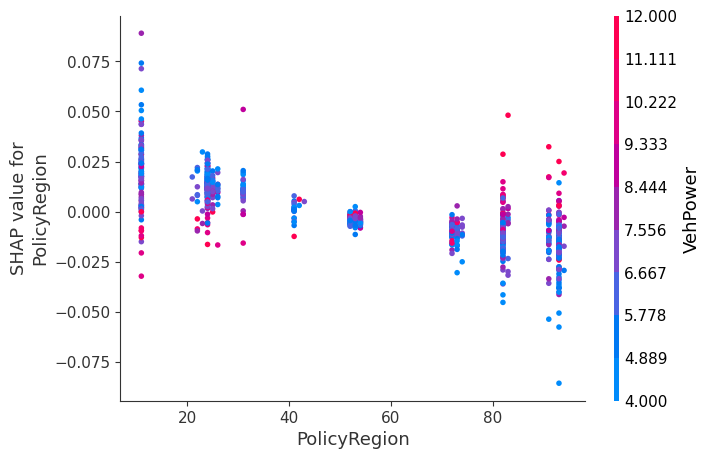

In [28]:
shap.dependence_plot(6, shap_nn2, X_explain)

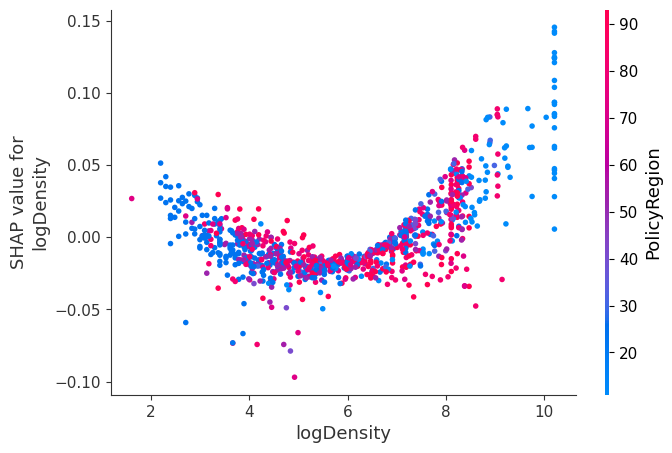

In [64]:
shap.dependence_plot("logDensity", shap_nn2, X_explain, interaction_index="PolicyRegion")